# Exploratory code to compare CT processing pipelines
    1. Dataset: ABIDE (https://riojournal.com/article/13726/) 
    2. Pipelines: ANTS, FreeSurfer, CIVET
    3. Atlas: DKT
    4. Plots: data distributoins, clusters, t-sne
    5. Analysis: statistical models (e.g. OLS, ML classifiers) 

In [3]:
# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Paths

In [4]:
data_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/'

ants_file = 'ABIDE_ants_thickness_data.csv'
fs53_file = 'ABIDE_fs5.3_thickness.csv'
fs51_file = 'cortical_fs5.1_measuresenigma_thickavg.csv'  
subject_chk_file = 'subject_check.csv'
pheno_file = 'ABIDE_Phenotype.csv'
outlier_file = 'ageOutliersAbide.csv'

## Read data

In [5]:
ants_data = pd.read_csv(data_dir + ants_file, header=2)
fs53_data = pd.read_csv(data_dir + fs53_file)
fs51_data = pd.read_csv(data_dir + fs51_file)
subject_ckh = pd.read_csv(data_dir + subject_chk_file)
pheno = pd.read_csv(data_dir + pheno_file)
outlier_data = pd.read_csv(data_dir + outlier_file)

In [6]:
subject_ckh.shape, pheno.shape, ants_data.shape, fs51_data.shape, fs53_data.shape

((1112, 7), (1112, 102), (1101, 99), (1112, 74), (976, 74))

## Create unified list of ROIs

In [7]:
# ANTS
ants_useful_cols = ['Structure Name']
ants_to_std_naming_dict = {}
ants_to_std_naming_dict['Structure Name'] = 'SubjID'
for roi in ants_data.columns:
    prefix = None
    name_split = roi.split(' ')
    if name_split[0] == 'left':
        prefix = 'L'
    if name_split[0] == 'right':
        prefix = 'R'

    if prefix is not None:
        ants_useful_cols.append(roi)
        std_name = prefix + '_' + ''.join(name_split[1:]) + '_thickavg'
        ants_to_std_naming_dict[roi] = std_name

In [8]:
# FS
fs_useful_cols = ['SubjID']
for roi in fs51_data.columns:
    prefix = None
    name_split = roi.split('_')
    if name_split[0] in ['L','R']:
        fs_useful_cols.append(roi)

In [28]:
# standardize common naming, subjects, and columns

ants_data_std = ants_data[ants_useful_cols]
ants_data_std = ants_data_std.rename(columns=ants_to_std_naming_dict)
print('ANTS data shape {}'.format(ants_data_std.shape))

fs51_data_std = fs51_data[fs_useful_cols]
fs53_data_std = fs53_data[fs_useful_cols]
print('FS 5.1 & 5.3 data shapes {}, {}'.format(fs51_data_std.shape, fs53_data_std.shape))

# Common columns 
common_cols = list(set(ants_data_std.columns) & set(fs51_data_std.columns))
common_roi_cols = common_cols.copy()
common_roi_cols.remove('SubjID')
ants_data_std = ants_data_std[common_cols]
ants_data_std['pipeline'] = np.tile('ants',len(ants_data_std))
fs51_data_std = fs51_data_std[common_cols]
fs51_data_std['pipeline'] = np.tile('fs51',len(fs51_data_std))
fs53_data_std = fs53_data_std[common_cols]
fs53_data_std['pipeline'] = np.tile('fs53',len(fs53_data_std))

# Common subjects
common_subs = list(set(ants_data_std['SubjID'].values) & set(fs51_data_std['SubjID'].values) & set(fs53_data_std['SubjID'].values))
ants_data_std = ants_data_std[ants_data_std['SubjID'].isin(common_subs)]
fs51_data_std = fs51_data_std[fs51_data_std['SubjID'].isin(common_subs)]
fs53_data_std = fs53_data_std[fs53_data_std['SubjID'].isin(common_subs)]

print('After selecting common subjects {} and columns {}\nData shapes for ants {}, FS 5.1 {}, FS 5.3 {}'.format(len(common_subs), 
                                                                                                                len(common_cols),
                                                                                                                ants_data_std.shape,
                                                                                                                fs51_data_std.shape,
                                                                                                                fs53_data_std.shape))


# Add the outlier column for each pipeline df
ants_data_std = pd.merge(ants_data_std,outlier_data[outlier_data['pipeline']=='ants'][['SubjID','adjPvalSumHim']],
                        how='left',on='SubjID')
ants_data_std = ants_data_std.fillna(0)
fs51_data_std = pd.merge(fs51_data_std,outlier_data[outlier_data['pipeline']=='fs51'][['SubjID','adjPvalSumHim']],
                        how='left',on='SubjID')
fs51_data_std = fs51_data_std.fillna(0)
fs53_data_std = pd.merge(fs53_data_std,outlier_data[outlier_data['pipeline']=='fs53'][['SubjID','adjPvalSumHim']],
                        how='left',on='SubjID')
fs53_data_std = fs53_data_std.fillna(0)

ANTS data shape (1101, 90)
FS 5.1 & 5.3 data shapes (1112, 69), (976, 69)
After selecting common subjects 975 and columns 63
Data shapes for ants (975, 64), FS 5.1 (975, 64), FS 5.3 (975, 64)


In [29]:
# Melt the longform df for plotting... 
master_data_df = ants_data_std.append(fs51_data_std).append(fs53_data_std)

master_data_df_melt = pd.melt(master_data_df, id_vars=['SubjID','pipeline','adjPvalSumHim'], 
                              value_vars=common_roi_cols, var_name='ROI', value_name='thickness')

#master_data_df_melt[['hemi','ROI','measure']] = master_data_df_melt['ROI'].str.split('_',expand=True)

## Plots: distributions

/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


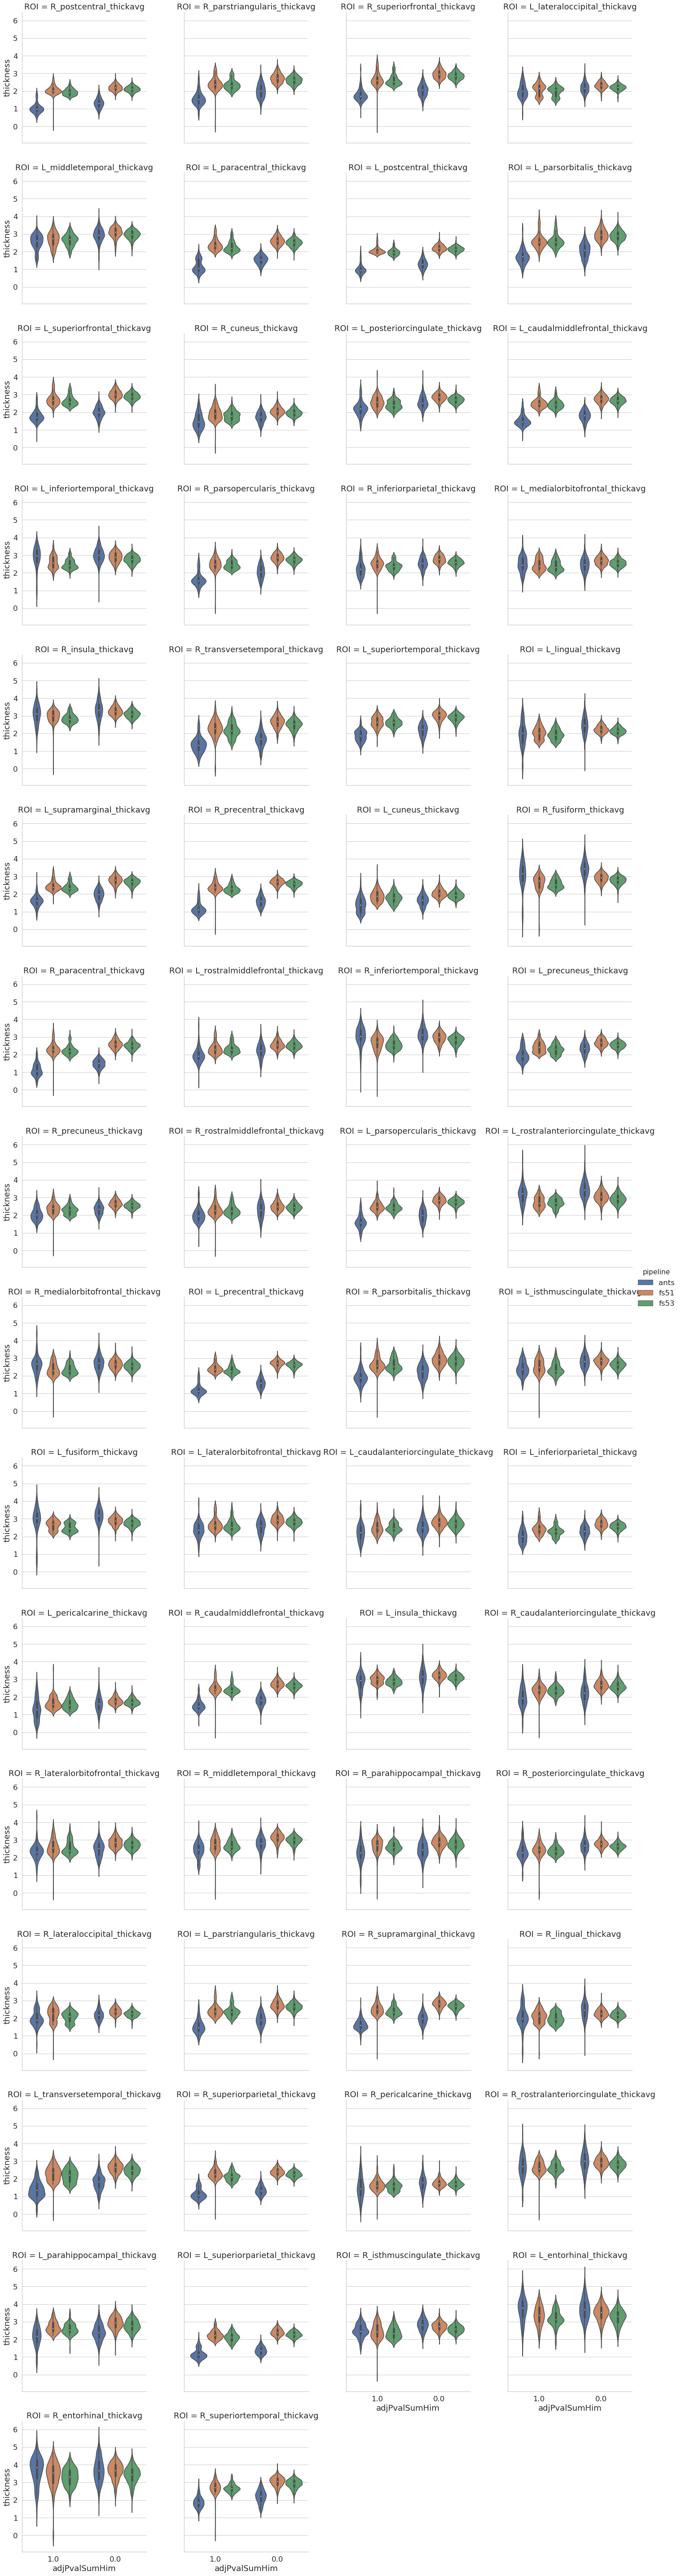

In [14]:
sns.set(font_scale=1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='thickness', x='adjPvalSumHim', hue='pipeline', kind='violin', col='ROI', col_wrap=4, 
                    data=master_data_df_melt)


## Filter df based on outliers and concat (horizontally)

In [ ]:
include_sub_tags = [0] # if 0 implies exclude outliers; else use [0,1]  

ants_data_std_filtered = ants_data_std[ants_data_std['adjPvalSumHim'].isin(include_sub_tags)]
ants_data_corr = ants_data_std_filtered[common_cols]
ants_data_corr.columns = [str(col) + '_ants' for col in ants_data_corr.columns]
ants_data_corr = ants_data_corr.rename(columns={'SubjID_ants':'SubjID'})

fs51_data_std_filtered = fs51_data_std[fs51_data_std['adjPvalSumHim'].isin(include_sub_tags)]
fs51_data_corr = fs51_data_std_filtered[common_cols]
fs51_data_corr.columns = [str(col) + '_fs51' for col in fs51_data_corr.columns]
fs51_data_corr = fs51_data_corr.rename(columns={'SubjID_fs51':'SubjID'})

fs53_data_std_filtered = fs53_data_std[fs53_data_std['adjPvalSumHim'].isin(include_sub_tags)]
fs53_data_corr = fs53_data_std_filtered[common_cols]
fs53_data_corr.columns = [str(col) + '_fs53' for col in fs53_data_corr.columns]
fs53_data_corr = fs53_data_corr.rename(columns={'SubjID_fs53':'SubjID'})

concat_df = ants_data_corr.merge(fs51_data_corr, on='SubjID').merge(fs53_data_corr, on='SubjID')

## Plots: correlations

avg corr:
ants-fs51 0.4395128902640136, ants-fs53 0.4758522422402297, fs51-fs53 0.8965521274604495


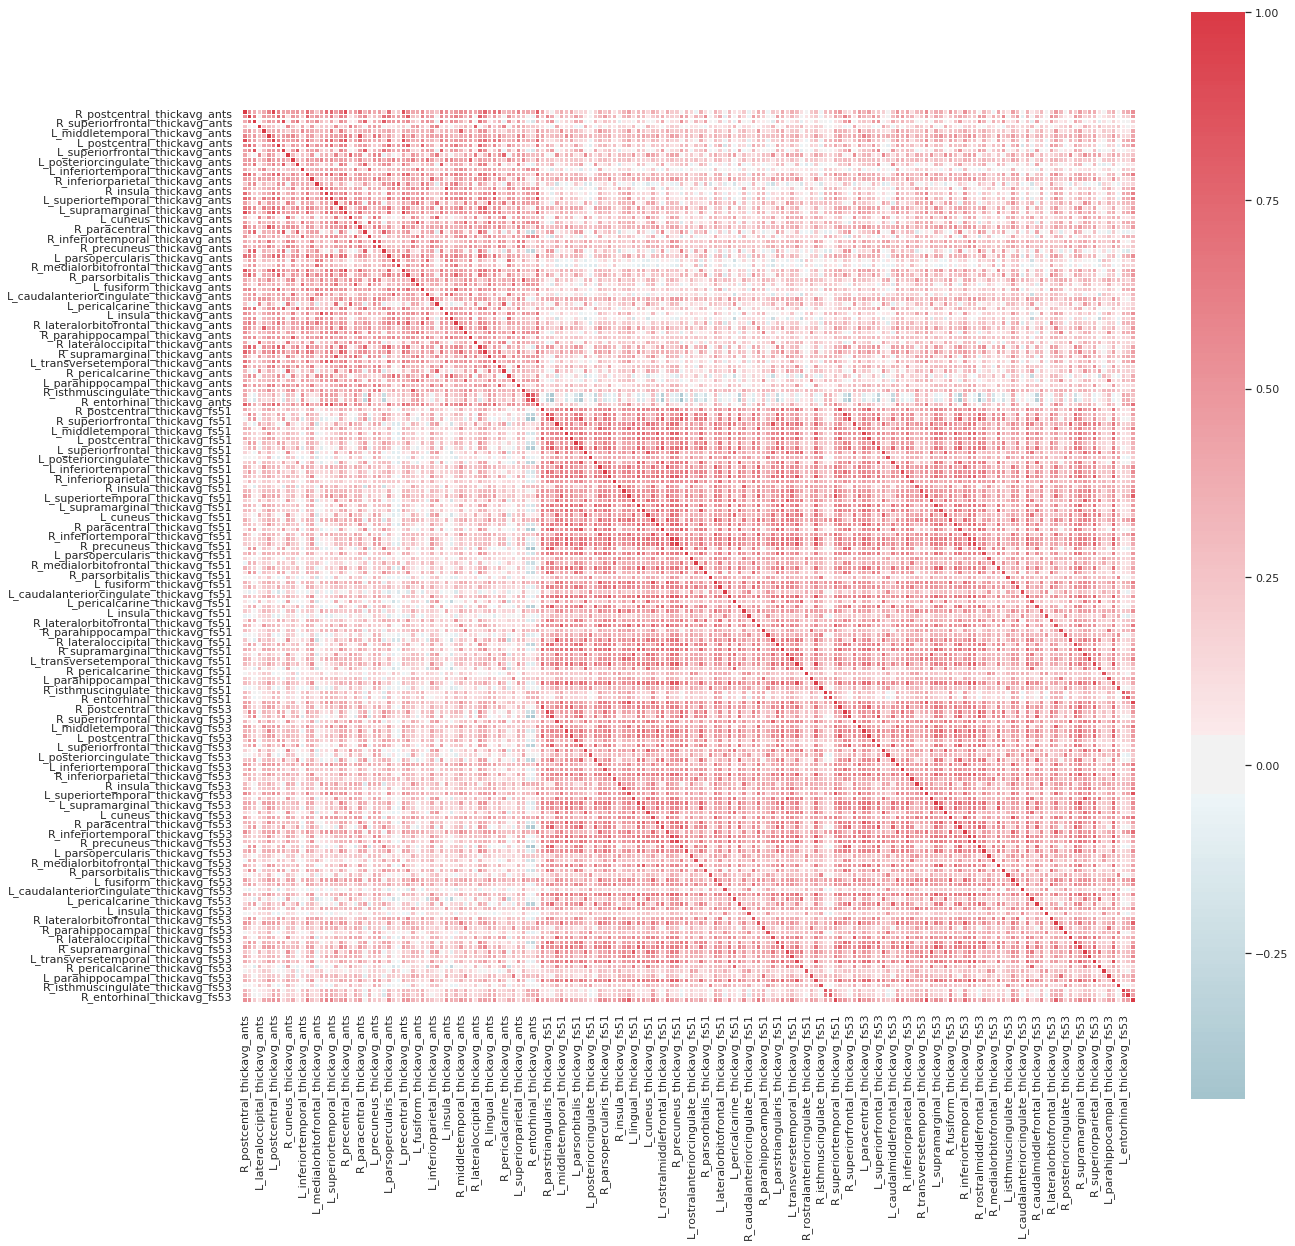

In [31]:
corr = concat_df.corr()

# avg cross-correlations using diangonals (corrwith from pandas doesn't work)
ants_fs51 = corr.values[:62,62:124].diagonal()
ants_fs53 = corr.values[:62,124:].diagonal()
fs51_fs53 = corr.values[62:124,124:].diagonal()

print('avg corr:\nants-fs51 {}, ants-fs53 {}, fs51-fs53 {}'.format(np.mean(ants_fs51),
                                                                   np.mean(ants_fs53),
                                                                   np.mean(fs51_fs53)))

# plot all pair-wise corrs (not really needed for seeing inter-pipeline comparisons)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#cmap = sns.diverging_palette(220, 20, n=7)

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(20,20))
sns.set(font_scale=1)
sns.heatmap(corr, cmap=cmap, square=True, linewidths=.5,center=0)


## Plots: clusters

Text(0.5, 0.98, 'fs5.3')

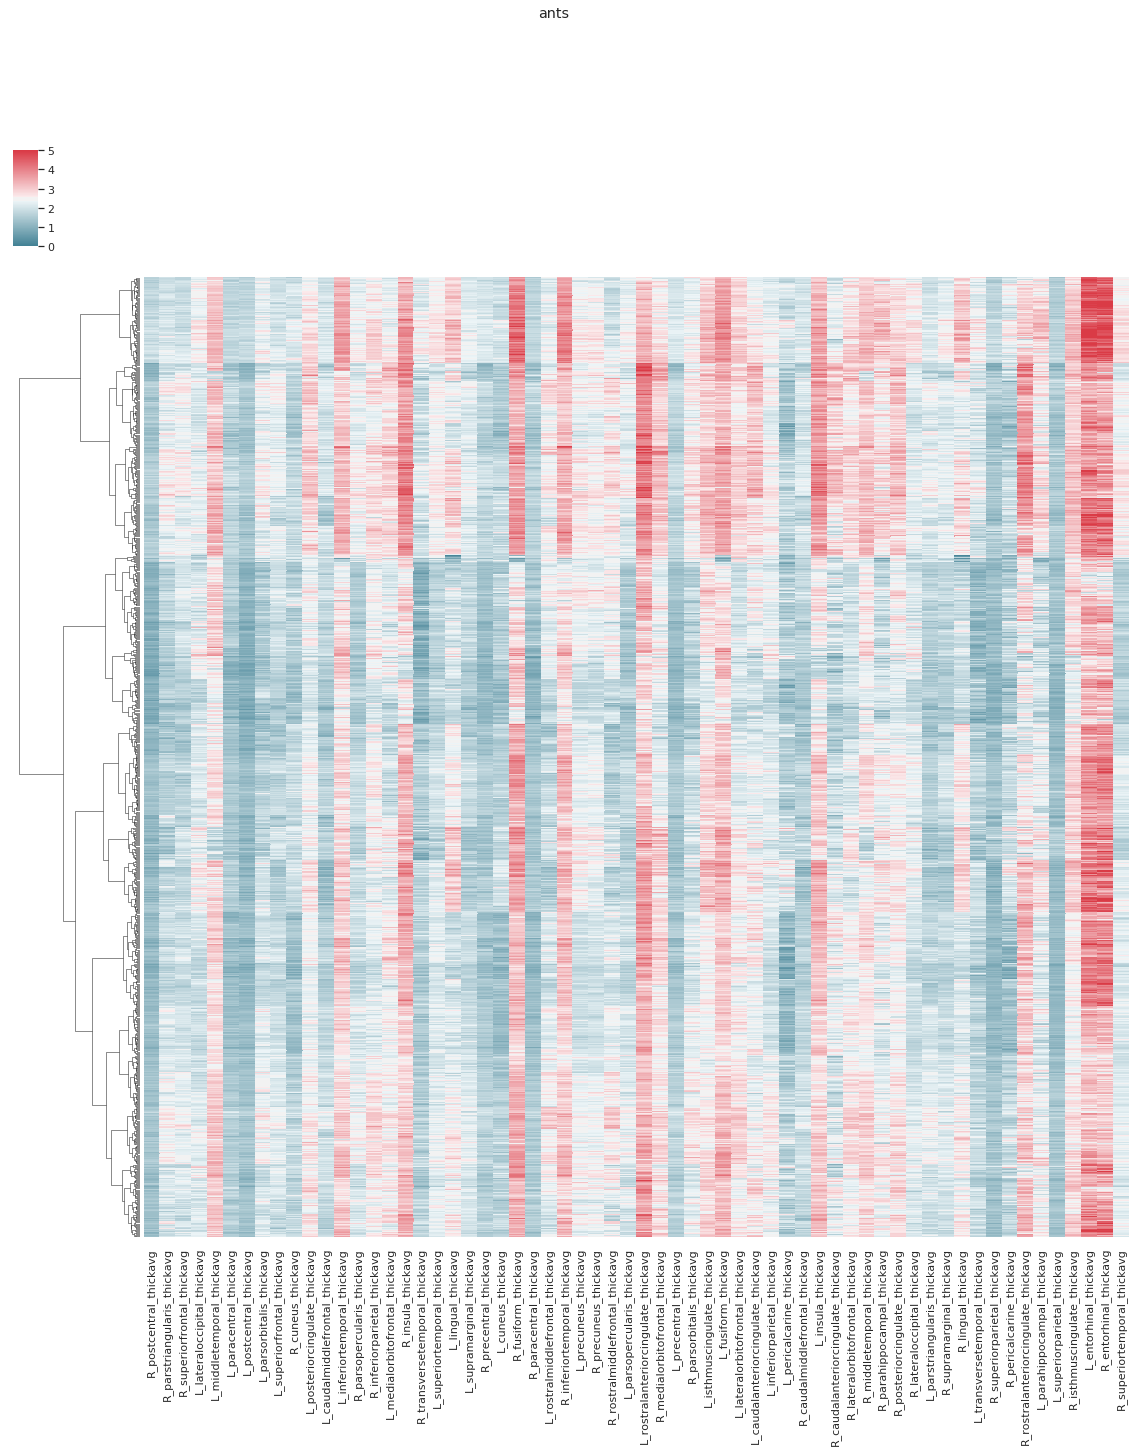

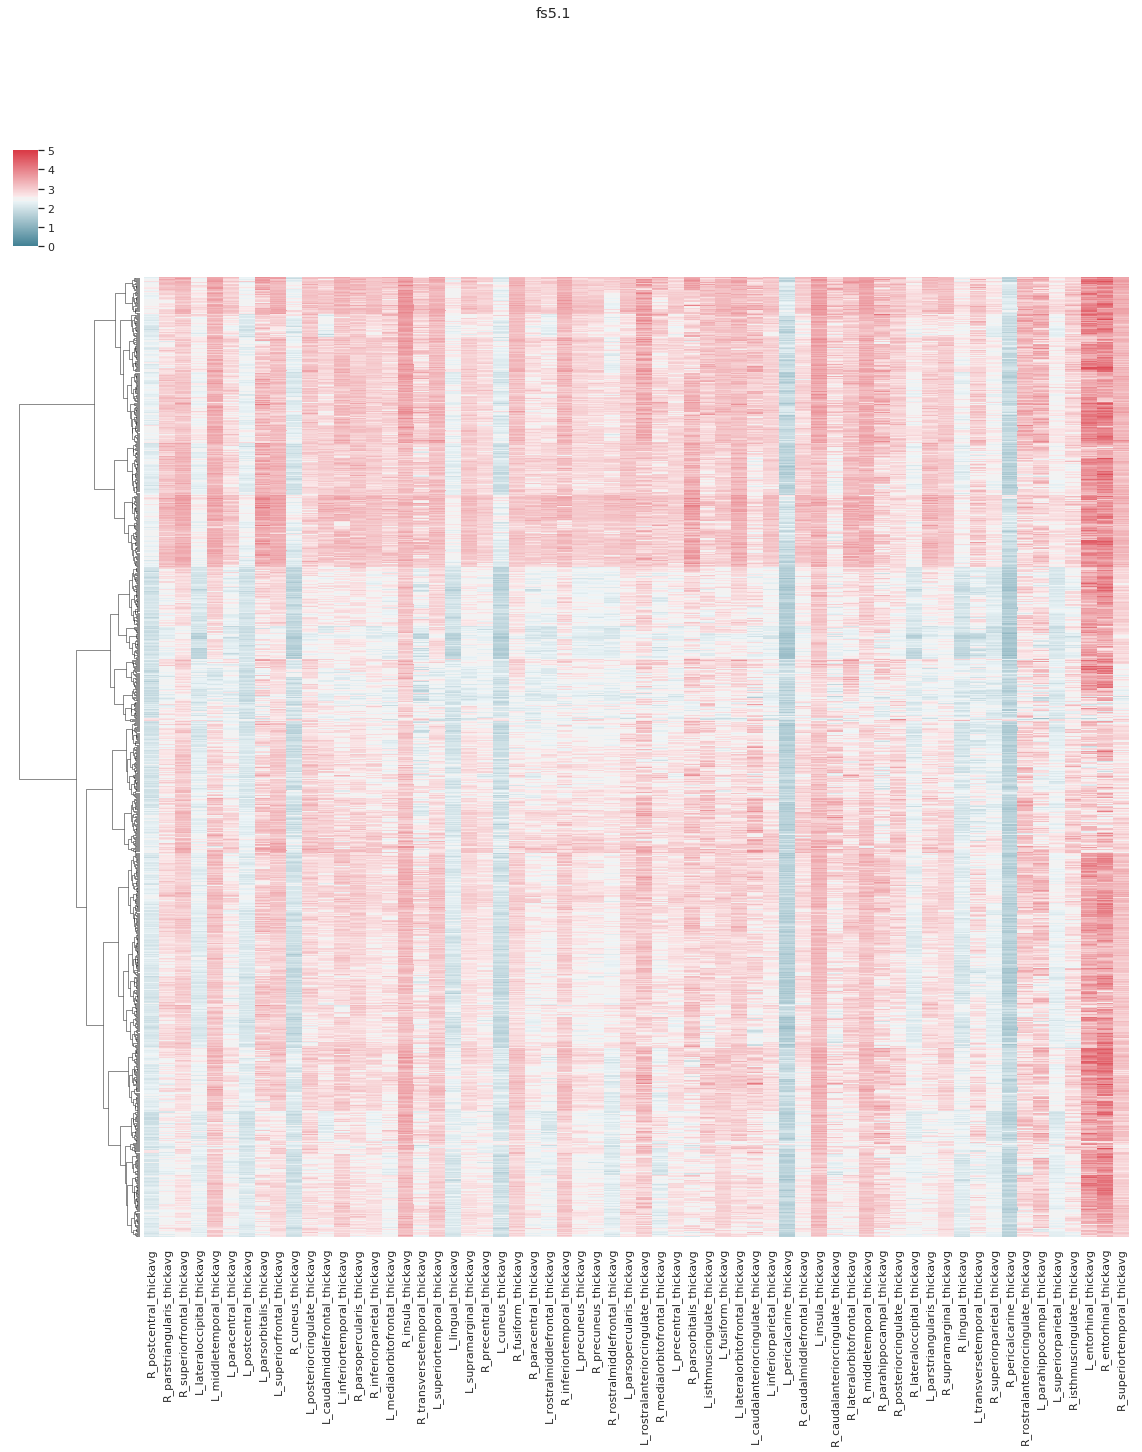

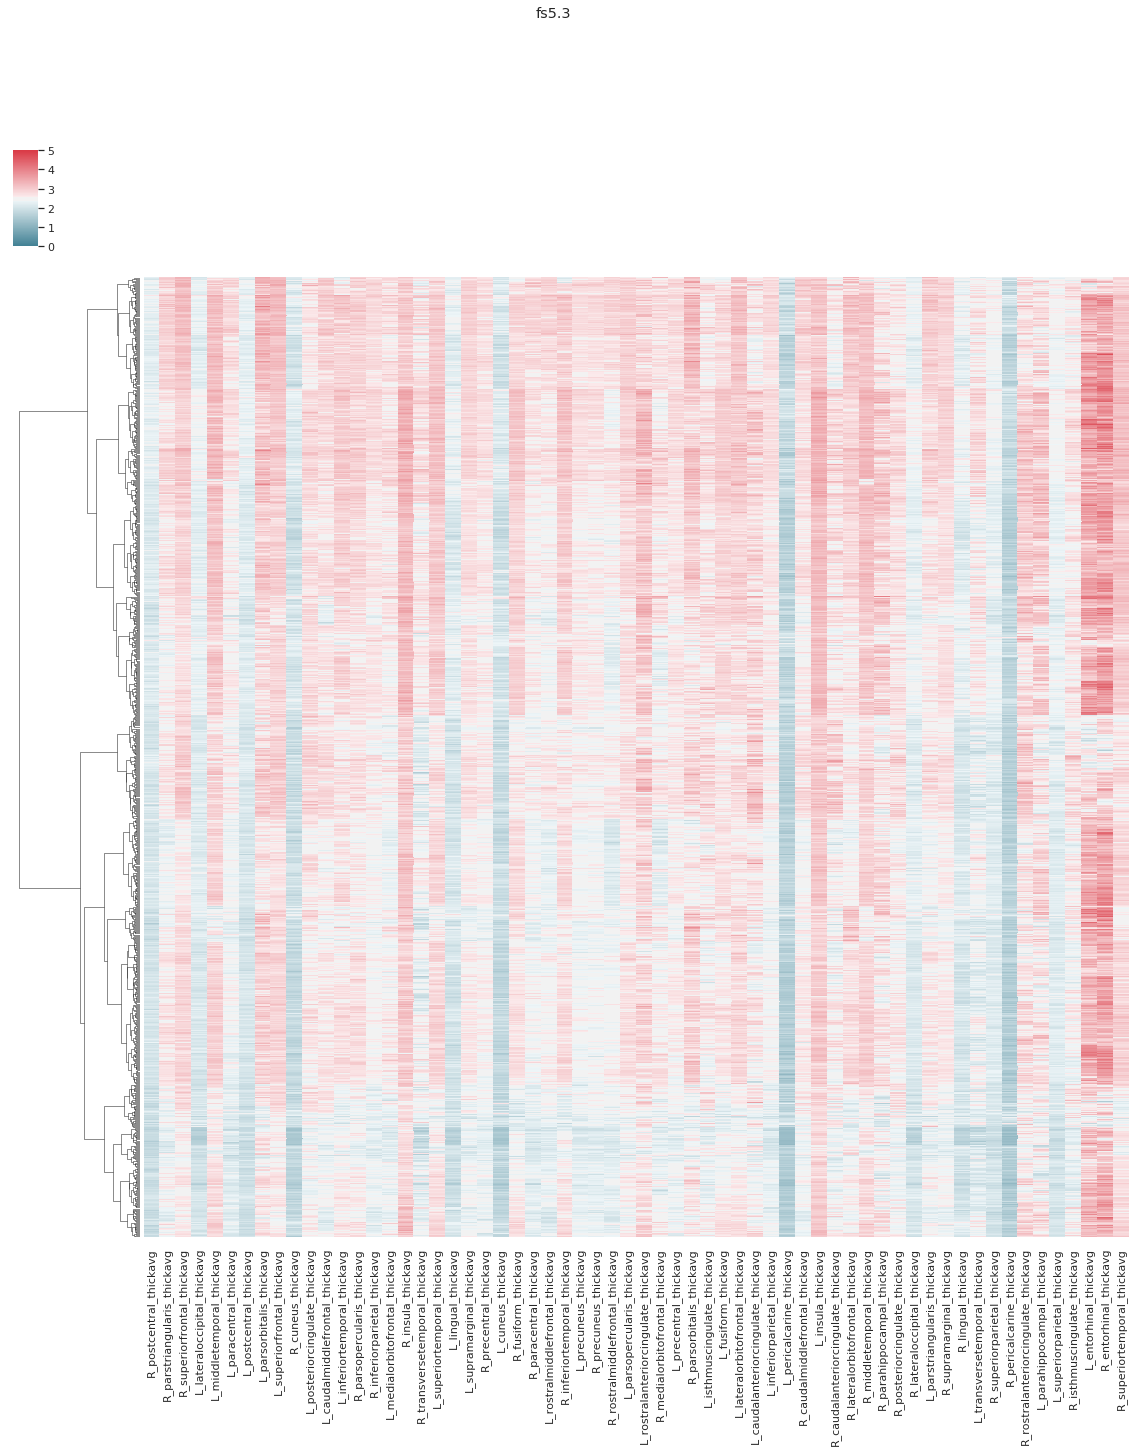

In [32]:
sns.set(style="white")
sns.set(font_scale=1)

similarity = 'euclidean'#'euclidean' #correlation
linkage = 'ward'

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

g1 = sns.clustermap(ants_data_std_filtered[common_roi_cols], row_cluster=True, col_cluster=False, metric = similarity, method=linkage, 
                   cmap=cmap, vmin=0, vmax=5, figsize=(20, 20),xticklabels=True, yticklabels=False)
g1.fig.suptitle('ants')

g2 = sns.clustermap(fs51_data_std_filtered[common_roi_cols], row_cluster=True, col_cluster=False, metric = similarity, method=linkage, 
                   cmap=cmap, vmin=0, vmax=5, figsize=(20, 20),xticklabels=True, yticklabels=False)
g2.fig.suptitle('fs5.1')

g3 = sns.clustermap(fs53_data_std_filtered[common_roi_cols], row_cluster=True, col_cluster=False, metric = similarity, method=linkage, 
                   cmap=cmap, vmin=0, vmax=5, figsize=(20, 20),xticklabels=True, yticklabels=False)
g3.fig.suptitle('fs5.3')

In [35]:
# cluster memberships
# Very basic - assumes same order of cluster-class for each pipeline 
# TODO - pairwise memberships

import scipy.cluster.hierarchy as sch
import collections

def get_cluster_membership(_df,g,n_clusters):
    member_df = _df[['SubjID','pipeline']].copy()
    Z = g.dendrogram_row.linkage
    T = sch.fcluster(Z, n_clusters, 'maxclust')
    member_count = collections.Counter(T)
    print('Pipeline {}, cluster sizes {}'.format(member_df['pipeline'].values[0], member_count))
    member_df['membership'] = T
    return member_df

def get_cluster_overlap(df1,df2):
    #assert len(df1) == len(df2)
    concat_df = pd.merge(df1,df2,on='SubjID',how='inner')
    overlap = np.sum(concat_df['membership_x'].values  == concat_df['membership_y'].values)/len(concat_df)
    return overlap                    

In [37]:
n_cluster = 2
print('Sanity check: largest and smallest clusters should have same cluster_ids across pipelines\n')
      
cluster_df = pd.DataFrame()
C1_member = get_cluster_membership(ants_data_std_filtered, g1, n_cluster)
C2_member = get_cluster_membership(fs51_data_std_filtered, g2, n_cluster)
C3_member = get_cluster_membership(fs53_data_std_filtered, g3, n_cluster)

C1_C2_overlap = get_cluster_overlap(C1_member,C2_member)
C1_C3_overlap = get_cluster_overlap(C1_member,C3_member)
C2_C3_overlap = get_cluster_overlap(C2_member,C3_member)

print('\ncluster membership overlap: C1_C2 {:3.2f}, C1_C3 {:3.2f}, C2_C3 {:3.2f}'.format(C1_C2_overlap,C1_C3_overlap,C2_C3_overlap))

Sanity check: largest and smallest clusters should have same cluster_ids across pipelines

Pipeline ants, cluster sizes Counter({2: 662, 1: 270})
Pipeline fs51, cluster sizes Counter({2: 659, 1: 285})
Pipeline fs53, cluster sizes Counter({2: 514, 1: 432})

cluster membership overlap: C1_C2 0.60, C1_C3 0.62, C2_C3 0.79


## Plot: t-SNE

In [39]:
from sklearn.manifold import TSNE
master_data_df_filtered = master_data_df[master_data_df['adjPvalSumHim'].isin(include_sub_tags)]
X = master_data_df_filtered[common_roi_cols].values
X_embedded = TSNE(n_components=2,init='pca').fit_transform(X)
X_embedded.shape

(2822, 2)

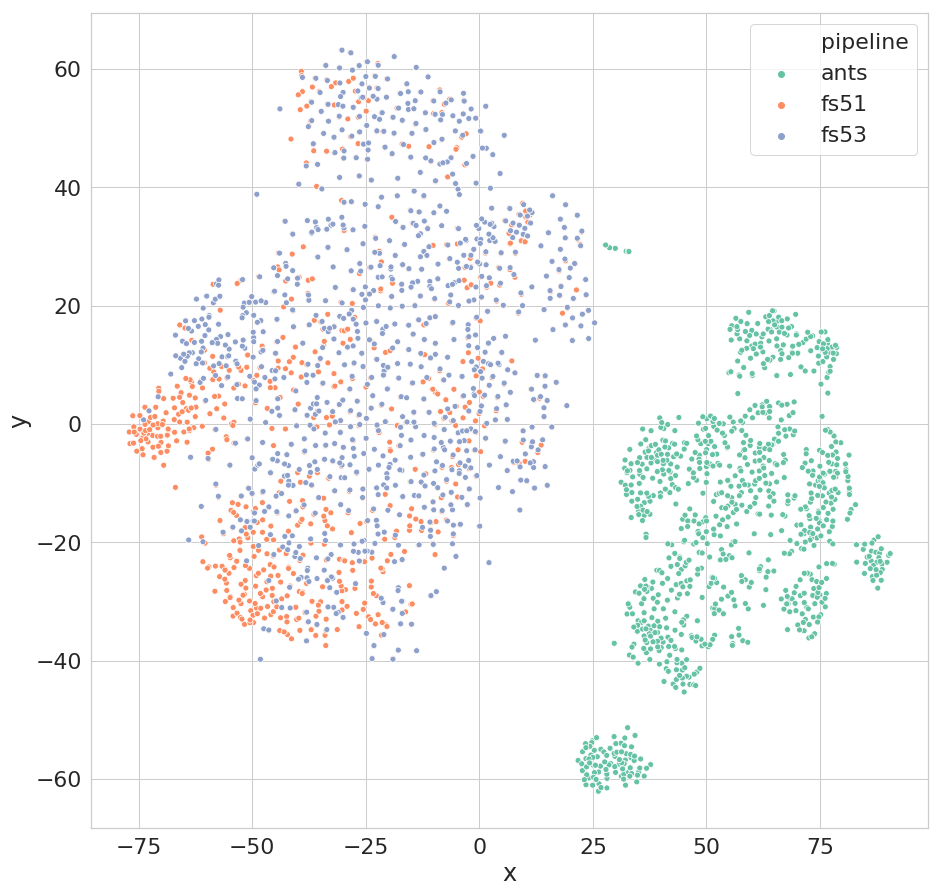

In [40]:
# plot
embed_df = pd.DataFrame(columns=['x','y'],data=X_embedded)
embed_df['pipeline'] = master_data_df_filtered['pipeline'].values

plt.figure(figsize=(15,15))
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    sns.scatterplot(x='x',y='y',hue='pipeline',data=embed_df,palette="Set2")

## ML classifier - sanity check

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn import svm

pipe_pairs = {'ants vs. fs5.1' : ['ants','fs51'],
              'ants vs. fs5.3' : ['ants','fs53'],
              'fs5.1 vs. fs5.3' : ['fs51','fs53']}

n_folds = 10
scores = pd.DataFrame(columns=pipe_pairs.keys())
for i, pair in enumerate(pipe_pairs.keys()):
    ml_df = master_data_df_filtered[master_data_df_filtered['pipeline'].isin(pipe_pairs[pair])]
    X = ml_df[common_roi_cols].values
    y = pd.get_dummies(ml_df['pipeline']).values[:,0]

    clf = svm.SVC(kernel='linear', C=1)
    acc = cross_val_score(clf, X, y, cv=n_folds)
    scores[pair] = acc

    print('pipelines {}, discriminative acc mean:{:4.3f}, stdev:{:4.3f}'.format(pair,np.mean(acc),np.std(acc)))

pipelines ants vs. fs5.3, discriminative acc mean:1.000, stdev:0.000
pipelines fs5.1 vs. fs5.3, discriminative acc mean:0.748, stdev:0.052
pipelines ants vs. fs5.1, discriminative acc mean:1.000, stdev:0.000


# Sample Research Question
* Predict age from cortical thickness

In [42]:
import statsmodels.api as sm

useful_demograph = pheno[['Subject_ID','SEX','DX_GROUP','AGE_AT_SCAN','FIQ','BMI']]
useful_demograph = useful_demograph.rename(columns={'Subject_ID':'SubjID'})
study_data_df = pd.merge(master_data_df_filtered, useful_demograph, how='left', on='SubjID')
print(study_data_df.shape)

(2822, 70)


In [43]:
# Save master df
#study_data_df.to_csv(data_dir + 'study_data_df.csv')

## OLS: age ~ cortical_thickness [+ sex + Dx] 

In [44]:
# For proof-of-concept, currently implemented as multiple regression instead of mass-univariate

results_df = pd.DataFrame(columns=common_roi_cols + ['pipeline','metric'])
p = 0
for pipe in set(study_data_df['pipeline'].values):
    analysis_df = study_data_df[study_data_df['pipeline']==pipe]
    y = analysis_df['AGE_AT_SCAN'].values

    # OLS
    t_val_list = []
    R2_adj_list = []
    for roi in common_roi_cols:
        X = analysis_df[[roi,'SEX','DX_GROUP']].values #[DX,SEX]
        model = sm.OLS(y,X)
        results = model.fit()
        t_val = results.tvalues[0] # just for ROI
        r2_adj_val = results.rsquared_adj
        t_val_list.append(t_val)
        R2_adj_list.append(r2_adj_val)
        
    results_df.loc[p] = list(t_val_list) + [pipe,'t_val']
    p+=1
    results_df.loc[p] = list(R2_adj_list) + [pipe,'r2_adj']
    p+=1

In [45]:
results_df

,R_postcentral_thickavg,R_parstriangularis_thickavg,R_superiorfrontal_thickavg,L_lateraloccipital_thickavg,L_middletemporal_thickavg,L_paracentral_thickavg,L_postcentral_thickavg,L_parsorbitalis_thickavg,L_superiorfrontal_thickavg,R_cuneus_thickavg,...,R_pericalcarine_thickavg,R_rostralanteriorcingulate_thickavg,L_parahippocampal_thickavg,L_superiorparietal_thickavg,R_isthmuscingulate_thickavg,L_entorhinal_thickavg,R_entorhinal_thickavg,R_superiortemporal_thickavg,pipeline,metric
0,13.553658,12.247178,11.947827,12.756070,15.195316,10.238506,13.781352,11.732855,12.209663,9.548608,...,9.877760,13.837749,14.235408,12.185520,11.859094,17.071263,17.444499,15.674329,fs53,t_val
1,0.831811,0.826624,0.825467,0.828619,0.838573,0.819151,0.832735,0.824645,0.826478,0.816763,...,0.817889,0.832965,0.834592,0.826385,0.825127,0.846488,0.848074,0.840581,fs53,r2_adj
2,12.650071,10.486994,10.645482,11.173565,13.656418,9.442038,12.637597,9.821091,10.933313,8.783392,...,9.399640,12.617503,13.414119,10.869453,10.918969,15.542227,16.521774,14.626777,fs51,t_val
3,0.826369,0.818101,0.818679,0.820639,0.830446,0.814424,0.826319,0.815730,0.819741,0.812236,...,0.814280,0.826239,0.829454,0.819504,0.819687,0.838341,0.842523,0.834475,fs51,r2_adj
4,13.169360,10.015216,10.540840,11.443186,14.505215,7.526399,13.860575,12.720116,11.667901,7.182922,...,5.192200,15.405081,11.652151,9.339969,10.394842,19.160897,18.962653,16.403859,ants,t_val
5,0.842861,0.831697,0.833446,0.836563,0.847960,0.824243,0.845480,0.841186,0.837360,0.823337,...,0.818785,0.851469,0.837304,0.829533,0.832955,0.866346,0.865562,0.855407,ants,r2_adj


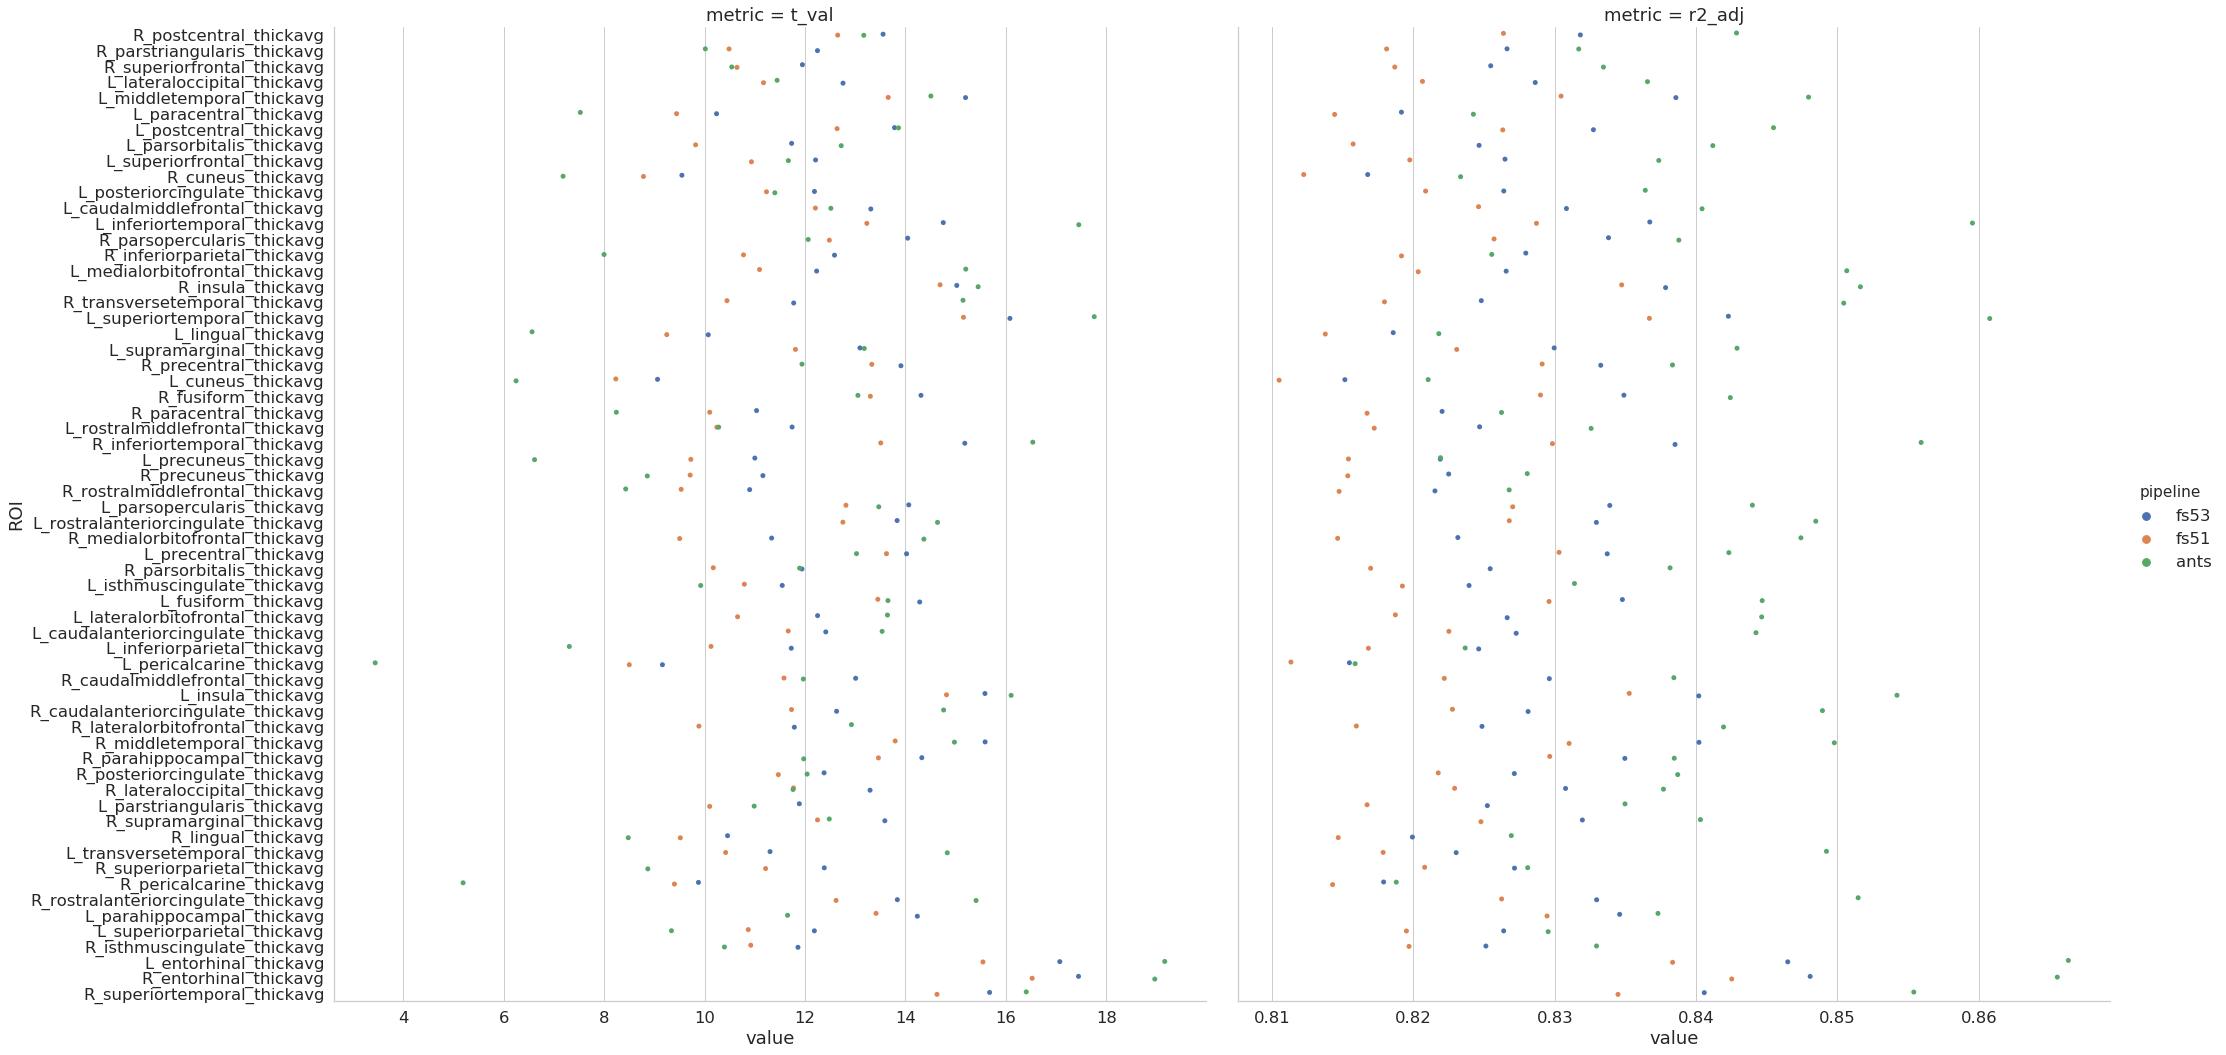

In [46]:
# Plot model results per pipeline

results_df_melt = pd.melt(results_df, id_vars=['pipeline','metric'], value_vars=common_roi_cols,
                             var_name='ROI', value_name='value')

sns.set(font_scale=1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x = 'value', y='ROI', hue='pipeline', col='metric', data=results_df_melt,
                    orient='h',kind='strip',aspect=1,height=15,sharex=False)
    #g.map(sns.stripplot, size=10)

In [ ]:
# Coe of variation across pipelines per ROI 
# List from John (Strict QC)
# CT differences based on age and Dx 
